In [1]:
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, SimpleRNN, BatchNormalization, RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error

tf.get_logger().setLevel('ERROR') # Setting log level for tensorflow

Num GPUs Available:  0


In [2]:
print(tf.__version__)

2.6.2


In [3]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())

['/device:CPU:0']


In [4]:
!python -V

Python 3.6.9 :: Anaconda, Inc.


##### Problem Statement

Let us define a sequence parity function as a function that takes in a sequence of binary inputs and returns a sequence indicating the number of 0’s in the input so far; specifically, if at time t the 0’s in the input so far is odd it returns 1, and 0 if it is even. For example, given input sequence [0, 1, 0, 1, 1, 0], the parity sequence is [1, 1, 0, 0, 0, 1]. 

 

Implement the minimal vanilla recurrent neural network to learn the parity function. Explain your rationale using a state transition diagram and parameters of the network.

##### Thought Process:

- Each parity bit is the XOR of the input and the previous parity bit.
- Parity is a classic example of a problem that’s hard to solve with a shallow feed-forward net, but easy to solve with an RNN.

###### Strategy:
- The output unit tracks the current parity, which is the XOR of the current input and previous output.
- Let’s use hidden units to help us compute XOR. Have one unit compute AND, and the other one compute OR.

In [5]:
def returnParity(xs):
    """
    Sequence indicating the number of 0’s in the input so far; 
    specifically, if at time t the 0’s in the input so far is odd it returns 1, and 0 if it is even.
    
    """
    ys = []
    count = 0
    if xs[0] == 0:
        count+=1
    ys.append(int(count%2==1))
    
    for x in xs[1:]:
        if x == 0:
            count+=1
        elif x==1:
            pass
        ys.append(int(count%2==1))
        
    return ys

def get_batch(input_length, batch_size):
    """
    Returns batch of parity sequence
    """
    X = []
    y = []
    for _ in range(batch_size):
        xs = [np.random.randint(0, 2) for _ in range(input_length)]
        ys = returnParity(xs)
        X.append(xs)
        y.append(ys)
    return X, y

get_batch(input_length=6, batch_size=2)

([[0, 1, 1, 1, 0, 1], [0, 1, 0, 1, 1, 0]],
 [[1, 1, 1, 1, 0, 0], [1, 1, 0, 0, 0, 1]])

In [6]:
testVal = [0, 1, 0, 1, 1, 0]
y_true = [1, 1, 0, 0, 0, 1]
returnParity(testVal) == y_true # Sample data check for function's correctness

True

In [7]:
def buildCheckpoints():
    """
    Adding model checkpoints for avoiding overfitting & 
    implementing dynamic learning rate for convergence
    """
    save_dir = os.path.join(os.getcwd(), "checkpoint")
    model_name = "model_callback.h5"
    filepath = os.path.join(save_dir, model_name)
    
    checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True)
    
    lr_reducer = ReduceLROnPlateau(factor=0.2, cooldown=0, patience=5, min_lr = 0.5e-6)
    early_stopping = EarlyStopping(monitor = 'val_loss', patience=5, verbose=0, mode='auto')
    
    callbacks = [checkpoint, lr_reducer, early_stopping]
    return callbacks

In [8]:
%%time

# LSTM layer expects inputs to have shape of (batch_size, timesteps, input_dim). 
# In keras you need to pass (timesteps, input_dim) for input_shape argument.

X, y = get_batch(input_length=6, batch_size=100000)
X, y = np.array(X), np.array(y) # As model accepts data as an array & not a list.

input_length = 6 # Taking parity sequence length as 6, this can be modified to our needs.
X = np.reshape(X, (X.shape[0], X.shape[1], 1)) # Reshaping as per LSTM model's input requirements

model = Sequential() # Building the Sequential model
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(input_length, 1)))
model.add(Dropout(0.2)) # Added Dropout Layer to minimize overfitting
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.2)) # Added Dropout Layer to minimize overfitting
model.add(Dense(1)) # Final sequence takes as a single output
model.compile(optimizer='adam', loss='mse') # As we are mapping 6 input seq to 6 output parity bits

print(model.summary()) # Model Architecture

history = model.fit(X, y, 
                    epochs=100, 
                    validation_split=0.25, 
                    verbose=0, 
                    batch_size=16,
                    callbacks=buildCheckpoints())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 64)             16896     
_________________________________________________________________
dropout (Dropout)            (None, 6, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 32)             12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 32)             0         
_________________________________________________________________
dense (Dense)                (None, 6, 1)              33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
None
Wall time: 4min 49s


##### Plot Model Loss to check for convergence & overfitting

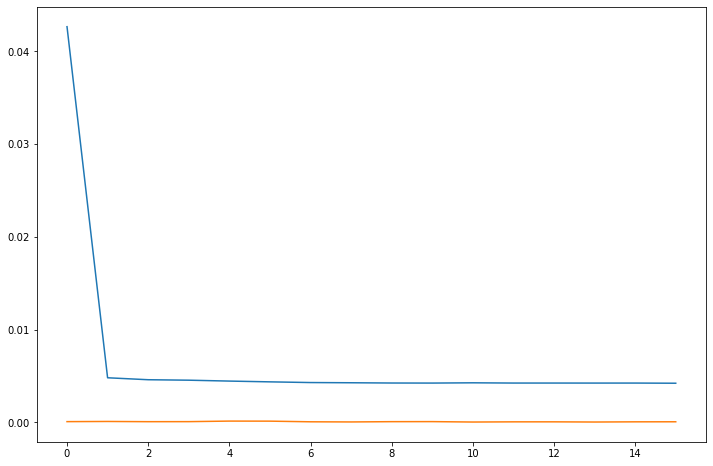

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

#### Using Vanilla RNN Network

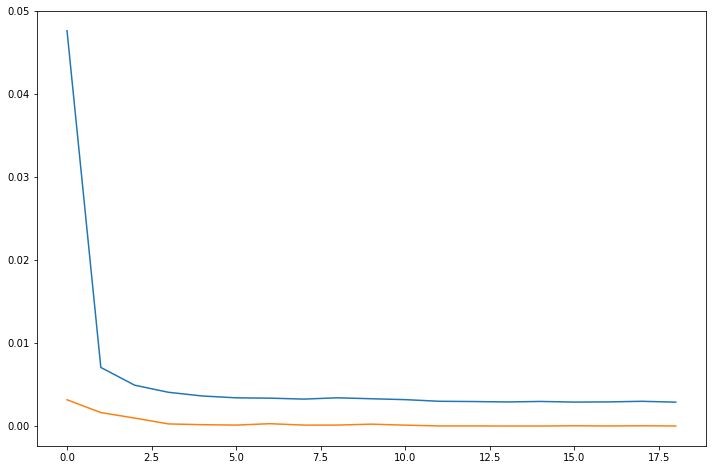

Wall time: 3min 28s


In [10]:
%%time

model = Sequential()
model.add(SimpleRNN(32, return_sequences=True, input_shape=(input_length, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.3)) 

model.add(SimpleRNN(16, return_sequences=True))
model.add(BatchNormalization())
model.add(Dense(1)) # Final sequence takes as a single output

model.compile(loss="mse", optimizer='adam')  # As we are mapping 6 input seq to 6 output parity bits

history = model.fit(X, y, epochs=100, 
                    validation_split=0.25, 
                    batch_size=16, verbose=0,
                    callbacks=buildCheckpoints())

plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [11]:
def validateModel(testVal, y_true):
    """
    Validate Model Errors
    """
    y_true = np.array(y_true)
    y_true = np.reshape(y_true, (y_true.shape[0], 1))
    X_test = np.array(testVal)
    X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))
    y_pred = model.predict(X_test)
    y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
    print("Test Sample : ", y_true.flatten())
    print("Prediction : ", y_pred.flatten())
    print("RMSE Error: ", np.sqrt(mean_squared_error(y_true, y_pred)))
    
validateModel(testVal, y_true)

Test Sample :  [1 1 0 0 0 1]
Prediction :  [ 9.9797577e-01 -5.7780743e-04  9.9797577e-01 -5.7780743e-04
 -5.7780743e-04  9.9797577e-01]
RMSE Error:  0.5769344911276896


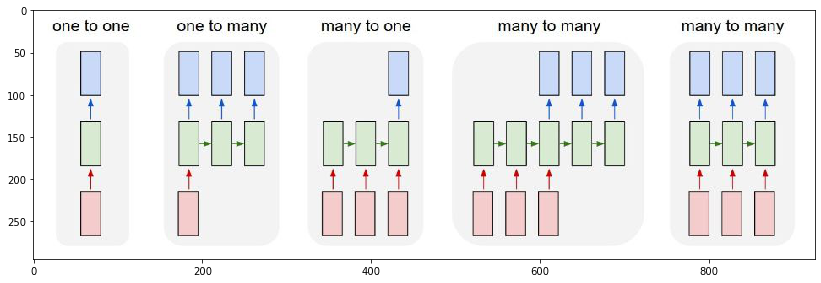

In [12]:
import matplotlib.image as mpimg
plt.figure(figsize=(14,10))
img = mpimg.imread('C:/Users/Abhishek/Desktop/Parity.JPG')
imgplot = plt.imshow(img)
plt.show()

##### References:
- https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec15.pdf